In [1]:

import pandas as pd

# Load the CSV file into a DataFrame to be used in the clustering process
df = pd.read_csv('Data/Partitioned_Abstracts.csv', sep=',', header=0, encoding='utf-8')

#verify that the DataFrame is loaded correctly
df.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1228 entries, 0 to 1227
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Title                 1228 non-null   object
 1   Year                  1228 non-null   int64 
 2   Authors               1228 non-null   object
 3   Label                 1228 non-null   object
 4   Partitioned Abstract  1228 non-null   object
 5   Target                1228 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 57.7+ KB


In [2]:
from sentence_transformers import SentenceTransformer

#Create the combined text by concatenating the "Title" and "Partitioned Abstract" columns
combined_texts = df["Title"].astype(str) + "\n\n" + df["Partitioned Abstract"].astype(str)
# Convert the "Target" column to integer type for classification purposes
targets = df["Target"].astype(int)

# Load the SentenceTransformer model for generating embeddings
model = SentenceTransformer("jinaai/jina-embeddings-v3", trust_remote_code=True)

# Define the task type for the model
task = "clustering"

# Encode the combined texts using the SentenceTransformer model
embeddings = model.encode(
    combined_texts.tolist(),
    show_progress_bar=True,
    device="cuda",
    convert_to_tensor=True,
)
embeddings.shape


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Batches:   0%|          | 0/39 [00:00<?, ?it/s]

torch.Size([1228, 1024])

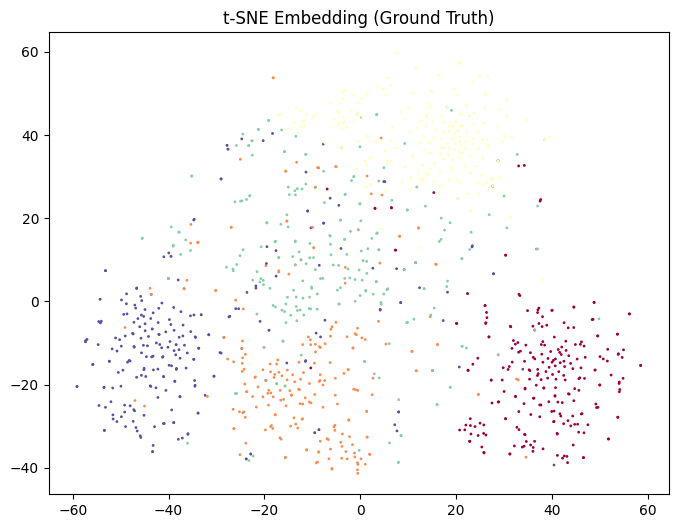

In [6]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Step 1: t-SNE on embeddings (for visualization)
tsne_embedding = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(
    embeddings.cpu().to(torch.float32).numpy()
)

# Step 2: Visualize t-SNE embedding colored by ground truth labels
plt.figure(figsize=(8, 6))
plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], c=targets, s=1, cmap='Spectral')
plt.title("t-SNE Embedding (Ground Truth)")
plt.show()


In [8]:
from sklearn.cluster import KMeans
import numpy as np

# Step 3: KMeans clustering on original embeddings
kmeans = KMeans(n_clusters=len(np.unique(targets)), random_state=42, n_init="auto")
labels_kmeans = kmeans.fit_predict(embeddings.cpu().to(torch.float32).numpy())


In [10]:
tsne_embedding_3d = TSNE(n_components=3, random_state=42, perplexity=30).fit_transform(
    embeddings.cpu().to(torch.float32).numpy()
)


In [12]:
kmeans_tsne = KMeans(n_clusters=len(np.unique(targets)), random_state=42, n_init="auto")
labels_kmeans_tsne = kmeans_tsne.fit_predict(tsne_embedding)


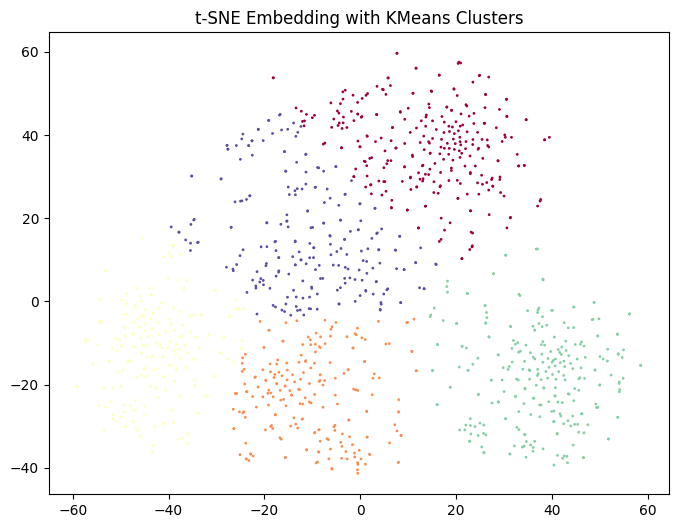

In [23]:
# Visualize KMeans clusters on t-SNE 2D
plt.figure(figsize=(8, 6))
plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], c=labels_kmeans_tsne, s=1, cmap='Spectral')
plt.title("t-SNE Embedding with KMeans Clusters")
plt.show()


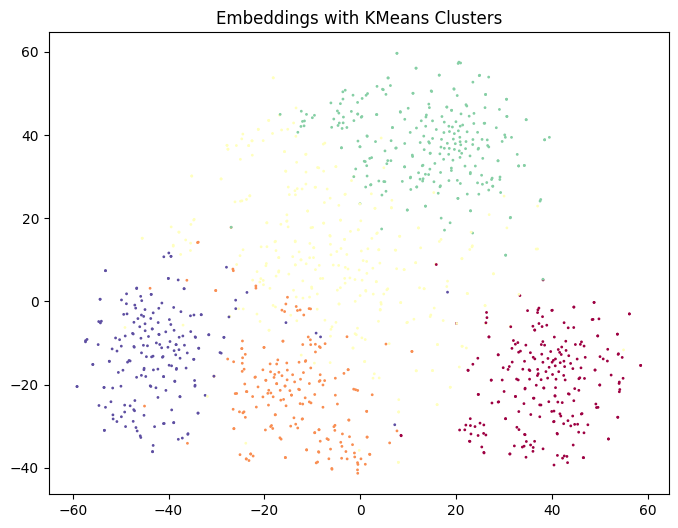

In [24]:
# Visualize KMeans clusters on t-SNE 2D
plt.figure(figsize=(8, 6))
plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], c=labels_kmeans, s=1, cmap='Spectral')
plt.title("Embeddings with KMeans Clusters")
plt.show()

In [25]:
import plotly.express as px
import pandas as pd

df_plot = pd.DataFrame(tsne_embedding_3d, columns=["x", "y", "z"])
df_plot["Cluster"] = labels_kmeans  # or labels_kmeans_tsne
df_plot["Title"] = df["Title"]

fig = px.scatter_3d(
    df_plot,
    x="x", y="y", z="z",
    color="Cluster",
    hover_name="Title",
    title="KMeans Clusters in t-SNE 3D",
    opacity=0.8
)
fig.update_layout(scene=dict(
    xaxis_title="X",
    yaxis_title="Y",
    zaxis_title="Z",
    bgcolor="lightgrey"
))
fig.write_html("kmeans_plotly.html")


In [26]:
import plotly.express as px
import pandas as pd

df_plot = pd.DataFrame(tsne_embedding_3d, columns=["x", "y", "z"])
df_plot["Cluster"] = labels_kmeans_tsne  # or labels_kmeans_tsne
df_plot["Title"] = df["Title"]

fig = px.scatter_3d(
    df_plot,
    x="x", y="y", z="z",
    color="Cluster",
    hover_name="Title",
    title="KMeans Clusters in t-SNE 3D",
    opacity=0.8
)
fig.update_layout(scene=dict(
    xaxis_title="X",
    yaxis_title="Y",
    zaxis_title="Z",
    bgcolor="lightgrey"
))
fig.write_html("tsne_kmeans_plotly.html")

In [15]:
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from scipy.optimize import linear_sum_assignment

# Function to align clusters to ground truth
def align_clusters(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm)
    mapping = {col: row for row, col in zip(row_ind, col_ind)}
    aligned = np.array([mapping.get(p, -1) for p in y_pred])
    return aligned

# Remove noise if necessary (not for KMeans, but keep the structure)
mask = np.ones_like(labels_kmeans, dtype=bool)
true_labels = df["Target"].values
cluster_labels = labels_kmeans[mask]
gt_labels = true_labels[mask]

aligned_preds = align_clusters(gt_labels, cluster_labels)
kappa = cohen_kappa_score(gt_labels, aligned_preds)
print(f"Cohen’s Kappa (KMeans vs. Target): {kappa:.4f}")


Cohen’s Kappa (KMeans vs. Target): 0.7650


In [18]:
# Remove noise if necessary (not for KMeans, but keep the structure)
mask = np.ones_like(labels_kmeans_tsne, dtype=bool)
true_labels = df["Target"].values
cluster_labels = labels_kmeans_tsne[mask]
gt_labels = true_labels[mask]

aligned_preds = align_clusters(gt_labels, cluster_labels)
kappa = cohen_kappa_score(gt_labels, aligned_preds)
print(f"Cohen’s Kappa (KMeans with t-sne embeddings vs. Target): {kappa:.4f}")

Cohen’s Kappa (KMeans with t-sne embeddings vs. Target): 0.7466
